# Task 2: Exploratory Data Analysis
## Ethiopia Financial Inclusion Forecasting

This notebook performs exploratory data analysis on the enriched dataset.

## 1. Setup and Load Enriched Data

In [10]:
import sys
import os
from pathlib import Path

# Add src to Python path
src_path = Path.cwd().parent / 'src'
sys.path.append(str(src_path))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Set plotting style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

# Import custom modules
from data_loader import load_and_prepare_data

## 2. Exploratory Data Analysis

In [11]:
# Load the enriched data
enriched_path = '../data/processed/ethiopia_fi_enriched.csv'
df_enriched = pd.read_csv(enriched_path)

print(f"Enriched dataset shape: {df_enriched.shape}")
print(f"Total records: {len(df_enriched)}")

# Separate by record type
observations = df_enriched[df_enriched['record_type'] == 'observation'].copy()
events = df_enriched[df_enriched['record_type'] == 'event'].copy()
impact_links = df_enriched[df_enriched['record_type'] == 'impact_link'].copy()
targets = df_enriched[df_enriched['record_type'] == 'target'].copy()

print(f"\nRecord type counts:")
print(f"  Observations: {len(observations)}")
print(f"  Events: {len(events)}")
print(f"  Impact links: {len(impact_links)}")
print(f"  Targets: {len(targets)}")

Enriched dataset shape: (51, 35)
Total records: 51

Record type counts:
  Observations: 31
  Events: 10
  Impact links: 7
  Targets: 3


In [12]:
# Check for missing values
print(f"Missing values in observations: {observations.isnull().sum().sum()}")
print(f"Missing values in events: {events.isnull().sum().sum()}")
print(f"Missing values in impact links: {impact_links.isnull().sum().sum()}")
print(f"Missing values in targets: {targets.isnull().sum().sum()}")

# Check for duplicates
print(f"Duplicates in observations: {observations.duplicated().sum()}")
print(f"Duplicates in events: {events.duplicated().sum()}")
print(f"Duplicates in impact links: {impact_links.duplicated().sum()}")
print(f"Duplicates in targets: {targets.duplicated().sum()}")

# Check for outliers (example: value_numeric > 1000)
if 'value_numeric' in observations.columns:
    print(f"Outliers in observations: {(observations['value_numeric'] > 1000).sum()}")
if 'value_numeric' in events.columns:
    print(f"Outliers in events: {(events['value_numeric'] > 1000).sum()}")
if 'value_numeric' in impact_links.columns:
    print(f"Outliers in impact links: {(impact_links['value_numeric'] > 1000).sum()}")
if 'value_numeric' in targets.columns:
    print(f"Outliers in targets: {(targets['value_numeric'] > 1000).sum()}")

Missing values in observations: 451
Missing values in events: 174
Missing values in impact links: 83
Missing values in targets: 46
Duplicates in observations: 0
Duplicates in events: 0
Duplicates in impact links: 0
Duplicates in targets: 0
Outliers in observations: 12
Outliers in events: 0
Outliers in impact links: 0
Outliers in targets: 1


## 3. Visualizations

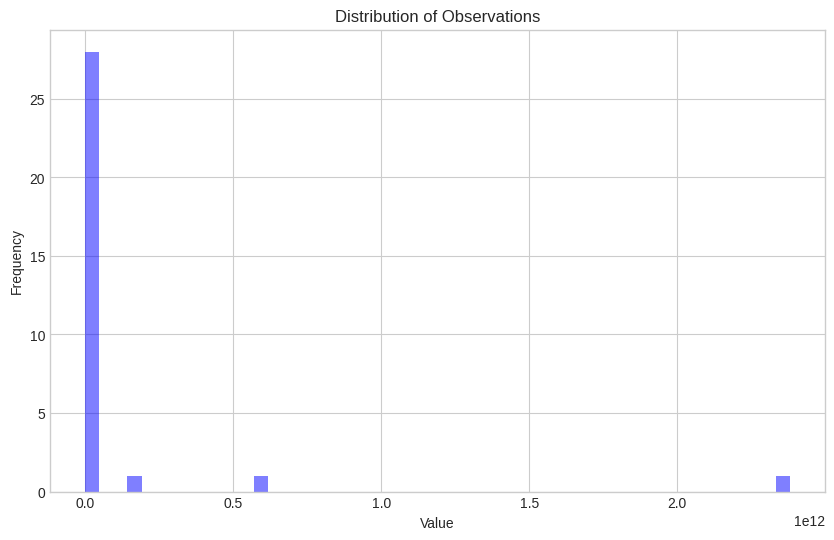

No numeric event values to plot.


<Figure size 1000x600 with 0 Axes>

In [19]:
# Plotting observations
plt.figure(figsize=(10, 6))
plt.hist(observations['value_numeric'], bins=50, color='blue', alpha=0.5)
plt.title('Distribution of Observations')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

# Plotting events
plt.figure(figsize=(10, 6))
event_values = events['value_numeric'].dropna()
if not event_values.empty:
    plt.hist(event_values, bins=50, color='green', alpha=0.5)
    plt.title('Distribution of Events')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.show()
else:
    print("No numeric event values to plot.")


## Impact Links Analysis

IMPACT LINKS ANALYSIS

Total impact links: 7

Columns in impact_links:
['record_id', 'record_type', 'category', 'pillar', 'indicator', 'indicator_code', 'indicator_direction', 'value_numeric', 'value_text', 'value_type', 'unit', 'observation_date', 'period_start', 'period_end', 'fiscal_year', 'gender', 'location', 'region', 'source_name', 'source_type', 'source_url', 'confidence', 'related_indicator', 'relationship_type', 'impact_direction', 'impact_magnitude', 'impact_estimate', 'lag_months', 'evidence_basis', 'comparable_country', 'collected_by', 'collection_date', 'original_text', 'notes', 'parent_id']

Impact estimates (non-null): 7 found
  Values: [4.749999999999999, 3.0, 1.5814889336016096, 2.0, 0.875, 0.05, 0.03]

Impact Links by Event:
           num_links         pillar impact_magnitude  \
parent_id                                              
EVT_0001           2         ACCESS     high, medium   
EVT_0003           2  ACCESS, USAGE     high, medium   
EVT_0004           2  

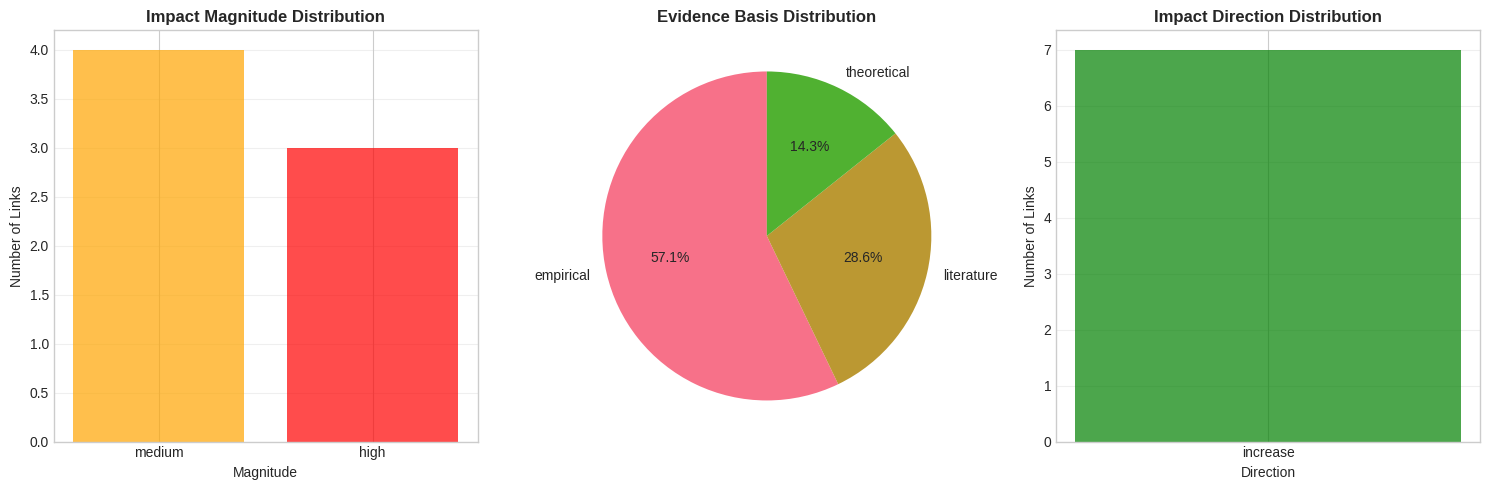

In [20]:
print("=" * 80)
print("IMPACT LINKS ANALYSIS")
print("=" * 80)

if not impact_links.empty:
    print(f"\nTotal impact links: {len(impact_links)}")

    # Columns overview
    print("\nColumns in impact_links:")
    print(impact_links.columns.tolist())

    # Impact estimates
    if 'impact_estimate' in impact_links.columns:
        non_null_estimates = impact_links['impact_estimate'].dropna()
        print(f"\nImpact estimates (non-null): {len(non_null_estimates)} found")
        if len(non_null_estimates) > 0:
            print("  Values:", non_null_estimates.tolist())

    # By event
    if 'parent_id' in impact_links.columns:
        event_impacts = impact_links.groupby('parent_id').agg({
            'record_id': 'count',
            'pillar': lambda x: ', '.join(sorted(x.dropna().unique())),
            'impact_magnitude': lambda x: ', '.join(sorted(x.dropna().unique()))
        }).rename(columns={'record_id': 'num_links'})

        if not events.empty and 'record_id' in events.columns:
            event_names = events.set_index('record_id')['indicator']
            event_impacts['event_name'] = event_impacts.index.map(event_names)

        print("\nImpact Links by Event:")
        print(event_impacts)

    # Magnitude distribution
    if 'impact_magnitude' in impact_links.columns:
        print(f"\nImpact Magnitude Distribution:")
        mag_counts = impact_links['impact_magnitude'].dropna().value_counts()
        for mag, count in mag_counts.items():
            print(f"  {mag}: {count} links")

    # Evidence basis
    if 'evidence_basis' in impact_links.columns:
        print(f"\nEvidence Basis Distribution:")
        evidence_counts = impact_links['evidence_basis'].dropna().value_counts()
        for evidence, count in evidence_counts.items():
            print(f"  {evidence}: {count} links")

    # Visualization
    import matplotlib.pyplot as plt
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Plot 1: Impact magnitude
    if 'impact_magnitude' in impact_links.columns:
        mag_counts = impact_links['impact_magnitude'].dropna().value_counts()
        colors = {'high': 'red', 'medium': 'orange', 'low': 'green', 'negligible': 'blue'}
        bar_colors = [colors.get(mag, 'gray') for mag in mag_counts.index]
        axes[0].bar(mag_counts.index, mag_counts.values, color=bar_colors, alpha=0.7)
        axes[0].set_title('Impact Magnitude Distribution', fontweight='bold')
        axes[0].set_xlabel('Magnitude')
        axes[0].set_ylabel('Number of Links')
        axes[0].grid(True, alpha=0.3, axis='y')

    # Plot 2: Evidence basis
    if 'evidence_basis' in impact_links.columns:
        evidence_counts = impact_links['evidence_basis'].dropna().value_counts()
        if not evidence_counts.empty:
            axes[1].pie(evidence_counts.values, labels=evidence_counts.index, 
                        autopct='%1.1f%%', startangle=90)
            axes[1].set_title('Evidence Basis Distribution', fontweight='bold')

    # Plot 3: Impact direction
    if 'impact_direction' in impact_links.columns:
        dir_counts = impact_links['impact_direction'].dropna().value_counts()
        colors_dir = {'increase': 'green', 'decrease': 'red', 'stabilize': 'blue', 'mixed': 'orange'}
        bar_colors_dir = [colors_dir.get(d, 'gray') for d in dir_counts.index]
        axes[2].bar(dir_counts.index, dir_counts.values, color=bar_colors_dir, alpha=0.7)
        axes[2].set_title('Impact Direction Distribution', fontweight='bold')
        axes[2].set_xlabel('Direction')
        axes[2].set_ylabel('Number of Links')
        axes[2].grid(True, alpha=0.3, axis='y')

    plt.tight_layout()
    plt.show()

else:
    print("No impact links found in dataset")

## 4. Summary

In [21]:
# Summary statistics
print(f"Summary statistics:")
print(f"  Observations: {observations.describe()}")
print(f"  Events: {events.describe()}")
print(f"  Impact links: {impact_links.describe()}")
print(f"  Targets: {targets.describe()}")

Summary statistics:
  Observations:        value_numeric  region  impact_estimate  lag_months
count   3.100000e+01     0.0              0.0         0.0
mean    1.004582e+11     NaN              NaN         NaN
std     4.362590e+11     NaN              NaN         NaN
min     1.080000e+00     NaN              NaN         NaN
25%     2.100000e+01     NaN              NaN         NaN
50%     5.600000e+01     NaN              NaN         NaN
75%     1.350000e+07     NaN              NaN         NaN
max     2.380000e+12     NaN              NaN         NaN
  Events:        value_numeric  region  impact_estimate  lag_months
count            0.0     0.0              0.0         0.0
mean             NaN     NaN              NaN         NaN
std              NaN     NaN              NaN         NaN
min              NaN     NaN              NaN         NaN
25%              NaN     NaN              NaN         NaN
50%              NaN     NaN              NaN         NaN
75%              NaN     N